## 데이터셋

1. **데이터셋 개요**

  데이터셋으로는 CIFAR-100 데이터셋을 사용하며, 이는 100개의 클래스(class)로 구성된 이미지 분류 데이터셋이다. 각 클래스는 600개의 이미지(총 60,000개)로 구성되어 있으며, 학습(train)과 테스트(test) 세트로 분리된다
  <br>

2. **재현성을 위한 시드 고정**

  실험의 재현성을 확보하기 위해 시드를 고정하였다
  <br>

3. **데이터셋 분할 (Labeled / Unlabeled)**

  반지도학습(semi-supervised learning)을 적용하기 위해 라벨이 있는 데이터(labeled)와 라벨이 없는 데이터(unlabeled)를 분리했다

      •	Labeled 데이터 (10%): 각 클래스당 60개의 이미지를 선택하여 labeled 데이터셋을 구성했다

      •	Unlabeled 데이터 (90%): 나머지 90%의 데이터를 unlabeled 데이터셋으로 활용했다
      <br>

4. **데이터 증강 (Labeled 데이터)**

  라벨이 있는 데이터는 모델의 일반화 성능을 향상시키기 위해 데이터 증강(data augmentation) 기법을 적용하였다

    •	RandomHorizontalFlip(): 50% 확률로 이미지를 좌우 반전하여 학습 데이터 다양성을 증가시켰다

    •	RandomCrop: 패딩을 추가하여 랜덤한 위치에서 지정한 크기로 이미지를 잘라냈다


In [1]:
import torch
import numpy as np
import random
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset
from collections import defaultdict

#  Seed 고정
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# CIFAR-100 기본 로드
base_transform = transforms.ToTensor()
train_dataset = datasets.CIFAR100(
    root='./data', train=True, download=True, transform=base_transform,
)

#  클래스별 인덱스 나누기
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset):
    class_indices[label].append(idx)

labeled_indices = []
unlabeled_indices = []

for indices in class_indices.values():
    np.random.shuffle(indices)
    labeled_indices.extend(indices[:60])      # 10%
    unlabeled_indices.extend(indices[60:])    # 90%

# Labeled Dataset
labeled_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

labeled_dataset = Subset(train_dataset, labeled_indices)
labeled_dataset.dataset.transform = labeled_transform

100%|██████████| 169M/169M [00:05<00:00, 29.7MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


## Unlabeled용 증강 정의

Unlabeled 데이터를 활용한 반지도 학습(Semi-Supervised Learning)에서는 **약한 증강(Weak Augmentation)**과 **강한 증강(Strong Augmentation)**을 적용하여 모델이 다양한 변형된 데이터를 학습하도록 유도했다

<br>

**약한 증강 (Weak Augmentation)**

약한 증강은 원본 데이터에 최소한의 변형을 적용하였다

  - 수평 뒤집기: 50% 확률로 이미지를 좌우로 뒤집어 변형된 데이터를 생성

  - 랜덤 자르기 : 원본 이미지 크기를 유지하면서 패딩을 추가하고 무작위로 잘라서 모델이 다양한 위치에서 특징을 학습할 수 있도록 하였다

<br>

**강한 증강 (Strong Augmentation)**

강한 증강은 원본 이미지에 보다 강력한 변형을 적용하여 모델이 보다 일반화된 표현을 학습하도록 유도한다

- 수평 뒤집기 : 50% 확률로 좌우 반전 적용
- 랜덤 자르기 : 약한 증강과 동일하게 랜덤 크롭 적용
- 색상 변화 : 밝기, 대비, 채도, 색조를 무작위로 변화시켜 모델이 색상 변화에 둔감해지도록 학습
- 랜덤 블러: 50% 확률로 가우시안 블러(Gaussian Blur)를 적용하여 이미지의 일부를 흐리게 적용


In [2]:
# Weak Augmentation
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

# Strong Augmentation
strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.5),
    transforms.ToTensor(),
])

## Unlabeled Dataset 클래스

•	UnlabeledDataset은 Weak Augmentation / Strong Augmentation을 적용한 이미지 쌍을 반환하는 데이터셋 클래스

•	라벨을 사용하지 않고, 같은 이미지에 대해 서로 다른 Augmentation을 적용하여 모델이 일관성(consistency)을 유지하도록 학습을 유도했다

•	반지도 학습에서 중요한 역할을 하는 데이터셋 클래스로, Pseudo-Labeling 및 Contrastive Learning과 함께 활용하였다

In [3]:
from torchvision.transforms.functional import to_pil_image

class UnlabeledDataset(Dataset):
    def __init__(self, dataset, indices, weak_transform, strong_transform):
        self.dataset = dataset
        self.indices = indices
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]  # 라벨은 사용하지 않음

        # Tensor로 변환된 경우 다시 PIL 이미지로 변환
        if isinstance(image, torch.Tensor):
            image = to_pil_image(image)  #  PIL 이미지로 변환

        weak_img = self.weak_transform(image)  #  PIL Image로 변환 후 적용
        strong_img = self.strong_transform(image)

        return weak_img, strong_img

In [4]:
unlabeled_dataset = UnlabeledDataset(
    train_dataset, unlabeled_indices, weak_transform, strong_transform
)

print(f"Labeled 데이터: {len(labeled_dataset)}장")
print(f"Unlabeled 데이터: {len(unlabeled_dataset)}장")

Labeled 데이터: 6000장
Unlabeled 데이터: 44000장


## Data 확인

Label: 19, Shape: torch.Size([3, 32, 32])


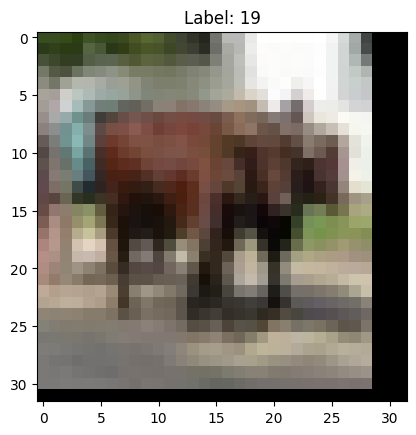

In [5]:
import matplotlib.pyplot as plt

# labled data 예시로 1개 확인
for i in range(1):
    img, label = labeled_dataset[i]
    print(f"Label: {label}, Shape: {img.shape}")
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.show()


## DataLoader

- labeled train	: 4,800장

- labeled val	: 1,200장

- unlabeled train : 	44,000장

- test : 10,000장

In [6]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


batch_size = 32

# Test 데이터셋 로드
test_transform = transforms.ToTensor()
test_dataset = datasets.CIFAR100(
    root='./data', train=False, download=True, transform=test_transform
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

#  Validation, Test용 Transform
basic_transform = transforms.ToTensor()

# labeled 데이터 80% / 20% 분리
train_indices, val_indices = train_test_split(
    labeled_indices, test_size=0.2, random_state=42
)

labeled_train_dataset = Subset(train_dataset, train_indices)
labeled_train_dataset.dataset.transform = labeled_transform

labeled_val_dataset = Subset(train_dataset, val_indices)
labeled_val_dataset.dataset.transform = basic_transform


labeled_train_loader = DataLoader(
    labeled_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

labeled_val_loader = DataLoader(
    labeled_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

unlabeled_dataset = UnlabeledDataset(
    train_dataset, unlabeled_indices, weak_transform, strong_transform
)

unlabeled_loader = DataLoader(
    unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)

Files already downloaded and verified


## Baseline 모델 정의

•	ResNet-18을 기반으로 CIFAR-100 분류 모델을 구성

•	기존 Fully Connected Layer를 Dropout이 적용된 새로운 FC Layer로 변경하여 과적합 방지

•	CrossEntropyLoss를 손실 함수로 사용

•	AdamW 옵티마이저와 Weight Decay(1e-4)를 적용

•	ReduceLROnPlateau 스케줄러 적용하여 Validation Loss에 따라 학습률을 동적으로 조절

In [7]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch

# ResNet-18 모델 생성
baseline_model = models.resnet18(pretrained=False)
num_features = baseline_model.fc.in_features  # 기존 Fully Connected layer의 입력 차원

# Dropout 추가된 새로운 Fully Connected Layer 적용
baseline_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout 적용 (50%)
    nn.Linear(num_features, 100)  # CIFAR-100 클래스 수
)

baseline_model = baseline_model.cuda()

# optimizer, loss 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(baseline_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train

In [8]:
import matplotlib.pyplot as plt

#  학습 과정 기록용 리스트 생성
baseline_train_losses = []
baseline_val_accuracies = []

epochs = 30

for epoch in range(epochs):
    baseline_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in labeled_train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = baseline_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(labeled_train_loader)
    train_acc = correct / total * 100

    #  Validation
    baseline_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for imgs, labels in labeled_val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = baseline_model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(labeled_val_loader)
    val_acc = val_correct / val_total * 100

    scheduler.step(val_loss)

    #  epoch별 결과 저장
    baseline_train_losses.append(train_loss)
    baseline_val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Val Acc: {val_acc:.2f}%")

Epoch [1/30] Train Loss: 4.7044 Val Acc: 5.08%
Epoch [2/30] Train Loss: 4.2653 Val Acc: 6.17%
Epoch [3/30] Train Loss: 4.0548 Val Acc: 7.50%
Epoch [4/30] Train Loss: 3.8666 Val Acc: 9.58%
Epoch [5/30] Train Loss: 3.7158 Val Acc: 8.33%
Epoch [6/30] Train Loss: 3.5530 Val Acc: 13.17%
Epoch [7/30] Train Loss: 3.3760 Val Acc: 15.33%
Epoch [8/30] Train Loss: 3.2299 Val Acc: 15.58%
Epoch [9/30] Train Loss: 2.9840 Val Acc: 14.92%
Epoch [10/30] Train Loss: 2.7534 Val Acc: 17.42%
Epoch [11/30] Train Loss: 2.5470 Val Acc: 19.92%
Epoch [12/30] Train Loss: 2.2947 Val Acc: 17.00%
Epoch [13/30] Train Loss: 2.0680 Val Acc: 17.00%
Epoch [14/30] Train Loss: 1.8034 Val Acc: 16.83%
Epoch [15/30] Train Loss: 1.5327 Val Acc: 15.92%
Epoch [16/30] Train Loss: 0.8880 Val Acc: 21.92%
Epoch [17/30] Train Loss: 0.5868 Val Acc: 22.17%
Epoch [18/30] Train Loss: 0.4090 Val Acc: 21.33%
Epoch [19/30] Train Loss: 0.3062 Val Acc: 20.92%
Epoch [20/30] Train Loss: 0.1936 Val Acc: 22.17%
Epoch [21/30] Train Loss: 0.1052 V

## Test

Baseline 모델 정확도 Accuracy: 21.96%

In [9]:
#  기록용 리스트 생성
baseline_test_loss = []
baseline_test_acc = []

#  Baseline Test 평가
baseline_model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = baseline_model(imgs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = outputs.max(1)
        test_correct += preds.eq(labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total * 100

baseline_test_loss.append(avg_test_loss)
baseline_test_acc.append(test_acc)

print(f"\n Baseline Test Result - Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.2f}%")


 Baseline Test Result - Loss: 5.4603, Accuracy: 21.96%


## ResNet Feature Extractor 준비
Semi-Supervised 학습에서 ResNet-18을 활용한 Feature Extractor를 구성하였다

ResNet의 사전 학습된 가중치를 활용하는 대신, 처음부터 학습 가능하도록 설정하였다

이 Feature Extractor는 Unlabeled Data이미지에서 유용한 특징(feature)을 추출하는 역할을 한다

In [10]:
import torchvision.models as models
import torch.nn as nn


# Feature Extractor (feature만 뽑음)
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=False)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_dim = resnet.fc.in_features

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x


feature_extractor = ResNetFeatureExtractor().cuda()
classifier = nn.Linear(feature_extractor.feature_dim, 100).cuda()

## Our 모델 정의

Semi-Supervised 학습을 위한 ResNet 기반 모델을 정의하였다

이 모델은 ResNet-18의 Feature Extractor를 활용하고, Classifier 부분에 Dropout을 추가하여 일반화 성능을 향상시키도록 설계되었다


In [11]:
import torch.nn as nn
import torchvision.models as models

class OurModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = ResNetFeatureExtractor()  # ResNet-18 기반 feature 추출

        # Dropout 추가
        self.dropout = nn.Dropout(p=0.5)  # Dropout 확률 50%
        self.classifier = nn.Linear(self.feature_extractor.feature_dim, 100)  # CIFAR-100 분류기

    def forward(self, x):
        features = self.feature_extractor(x)  # (batch_size, 512)
        features = self.dropout(features)  #  Dropout 적용
        outputs = self.classifier(features)  # (batch_size, 100)
        return outputs

#  모델 생성
model = OurModel().cuda()

## 손실 함수, optimizer 설정

•	CrossEntropyLoss를 손실 함수로 사용

•	AdamW 옵티마이저와 Weight Decay(1e-4)를 적용

In [12]:
import torch.nn.functional as F

# 손실 함수
ce_loss = nn.CrossEntropyLoss()
mse_loss = nn.MSELoss()

# 옵티마이저
params = list(model.parameters())
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

## Contrastive Loss (NT-Xent Loss) 계산


Contrastive Learning은 유사한 샘플(positive pair)은 가까이, 서로 다른 샘플(negative pair)은 멀리 배치하도록 학습하는 방법이다

여기서는 NT-Xent(Normalized Temperature-scaled Cross Entropy) Loss를 사용하여 모델이 의미 있는 Feature Embedding을 학습하도록 하였다

<br>


NT-Xent Loss 개념

•	두 개의 서로 다른 변환(augmentation)된 이미지 쌍을 입력으로 받아 Cosine Similarity를 기반으로 유사도를 계산한다

•	온도 매개변수(Temperature Scaling) 를 사용하여 학습을 조정한다

•	같은 샘플에서 나온 두 Feature Vector(Positive Pair)는 높은 유사도(1에 가까운 값) 를 가지도록 유도한다

•	서로 다른 샘플에서 나온 Feature Vector(Negative Pair)는 낮은 유사도(-1에 가까운 값) 를 가지도록 학습한다

In [14]:
import torch
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.8):
    batch_size = z1.size(0)  # 보통 64

    # Feature 정규화
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Representations 병합 (배치 크기 2배 증가)
    representations = torch.cat([z1, z2], dim=0)  # (2 * batch_size, 512)

    # Cosine Similarity 계산
    similarity_matrix = F.cosine_similarity(
        representations.unsqueeze(1), representations.unsqueeze(0), dim=2
    )

    # 자기 자신 제외하는 마스크
    mask = torch.eye(2 * batch_size, dtype=torch.bool).cuda()

    #  Similarity 값 → exp(similarity / temperature)
    exp_sim = torch.exp(similarity_matrix / temperature)

    # 분모: 자기 자신 제외하고 합산
    exp_sim_sum = exp_sim.masked_fill(mask, 0).sum(dim=1, keepdim=True)

    # Positive pair 계산 수정
    positive_sim = torch.exp(
        F.cosine_similarity(z1, z2, dim=1) / temperature
    )

    #  Loss 계산 (분모/분자 차원 맞추기)
    loss = -torch.log(positive_sim / exp_sim_sum[:batch_size].squeeze()).mean()

    return loss

## Pseudo-label loss 계산

Pseudo-Labeling 개념

•	Pseudo-Labeling은 라벨이 없는 데이터(unlabeled data)에 대해 모델이 예측한 값 중 신뢰도가 높은 데이터를 활용하는 기법이다

•	이 과정에서 신뢰도 높은 예측값을 가짜 라벨(Pseudo-Label)로 간주하고, 라벨이 있는 데이터처럼 학습에 활용한다

•	일정한 신뢰도(Threshold) 이상의 예측값만 선택하여 사용함으로써 노이즈를 최소화한다

In [15]:
import torch.nn.functional as F
import torch.nn as nn

pseudo_label_threshold = 0.1
ce_loss = nn.CrossEntropyLoss()

for weak_img, strong_img in unlabeled_loader:
    weak_img = weak_img.cuda()
    strong_img = strong_img.cuda()

    # weak 이미지로 예측값 얻기
    weak_logits = model(weak_img)  # (batch_size, num_classes)
    pseudo_probs = F.softmax(weak_logits, dim=1)

    # 최대 확률값과 클래스 추출
    max_probs, pseudo_labels = torch.max(pseudo_probs, dim=1)

    # threshold 이상인 데이터만 사용
    mask = max_probs.ge(pseudo_label_threshold).float()

    # strong 이미지로 예측값 얻기
    strong_logits = model(strong_img)

    # pseudo-label과 strong 이미지로 CrossEntropyLoss 계산
    pseudo_label_loss = (ce_loss(strong_logits, pseudo_labels) * mask).mean()

## Consistency loss

Consistency Loss 개념

•	Consistency Loss는 동일한 이미지에 서로 다른 Augmentation을 적용했을 때, 모델이 일관된 예측을 하도록 유도하는 손실 함수이다

•	약한 증강(Weak Augmentation)과 강한 증강(Strong Augmentation)된 이미지의 예측 확률 분포가 유사해야 한다는 가정을 기반으로 한다

•	이를 통해 모델이 데이터 증강에도 강인한(robust) Feature Representation을 학습할 수 있도록 하였다

In [22]:
mse_loss = nn.MSELoss()

# weak, strong 이미지 예측 확률
weak_probs = F.softmax(model(weak_img), dim=1)
strong_probs = F.softmax(model(strong_img), dim=1)

# consistency loss 계산
consistency_loss = mse_loss(weak_probs, strong_probs)

## Train

In [19]:
epochs = 30
warmup_epochs = 5  #  초반 5 Epoch 동안은 Supervised Loss만 학습
pseudo_label_threshold = 0.8  # Pseudo-Label 적용 임계값 조정

# 학습 기록 저장용
our_train_losses = []
our_val_accuracies = []

for epoch in range(epochs):
    model.train()

    total_loss = 0
    unlabeled_iter = iter(unlabeled_loader)

    for labeled_imgs, labels in labeled_train_loader:
        try:
            weak_imgs, strong_imgs = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_imgs, strong_imgs = next(unlabeled_iter)

        # labeled 데이터
        labeled_imgs, labels = labeled_imgs.cuda(), labels.cuda()
        labeled_logits = model(labeled_imgs)
        supervised_loss = ce_loss(labeled_logits, labels)

        #  unlabeled 데이터
        weak_imgs, strong_imgs = weak_imgs.cuda(), strong_imgs.cuda()

        if epoch >= warmup_epochs:  #  Warm-up 적용
            weak_logits = model(weak_imgs)
            pseudo_probs = F.softmax(weak_logits, dim=1)
            max_probs, pseudo_labels = pseudo_probs.max(dim=1)
            mask = (max_probs >= pseudo_label_threshold).float()

            #  적용 비율 확인
            pseudo_label_ratio = mask.mean().item()

            if pseudo_label_ratio > 0.2:  # 최소 0.2 이상 적용될 때만 학습
                strong_logits = model(strong_imgs)
                pseudo_label_loss = (ce_loss(strong_logits, pseudo_labels) * mask).mean()
                consistency_loss = mse_loss(pseudo_probs, F.softmax(strong_logits, dim=1))
                contrastive_loss = nt_xent_loss(weak_logits, strong_logits)
            else:
                pseudo_label_loss = torch.tensor(0.0).cuda()
                consistency_loss = torch.tensor(0.0).cuda()
                contrastive_loss = torch.tensor(0.0).cuda()
        else:
            pseudo_label_loss = torch.tensor(0.0).cuda()
            consistency_loss = torch.tensor(0.0).cuda()
            contrastive_loss = torch.tensor(0.0).cuda()

        # total loss
        λ1, λ2, λ3 = 0.5, 0.5, 0.5
        total_batch_loss = supervised_loss + λ1 * pseudo_label_loss + λ2 * consistency_loss + λ3 * contrastive_loss

        # 학습 업데이트
        optimizer.zero_grad()
        total_batch_loss.backward()
        optimizer.step()

        total_loss += total_batch_loss.item()

    avg_train_loss = total_loss / len(labeled_train_loader)
    our_train_losses.append(avg_train_loss)

    #  Validation
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()

    with torch.no_grad():
        for imgs, labels in labeled_val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            loss = ce_loss(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(labeled_val_loader)
    val_acc = val_correct / val_total * 100

    scheduler.step(avg_val_loss)
    our_val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} "
          f" Val Acc: {val_acc:.2f}%")

Epoch [1/30] Train Loss: 3.6459  Val Acc: 13.58%
Epoch [2/30] Train Loss: 3.4800  Val Acc: 12.25%
Epoch [3/30] Train Loss: 3.2761  Val Acc: 11.33%
Epoch [4/30] Train Loss: 3.0838  Val Acc: 15.50%
Epoch [5/30] Train Loss: 2.9172  Val Acc: 14.67%
Epoch [6/30] Train Loss: 2.6628  Val Acc: 18.58%
Epoch [7/30] Train Loss: 2.4376  Val Acc: 17.42%
Epoch [8/30] Train Loss: 2.1862  Val Acc: 18.67%
Epoch [9/30] Train Loss: 1.5629  Val Acc: 22.17%
Epoch [10/30] Train Loss: 1.3254  Val Acc: 21.42%
Epoch [11/30] Train Loss: 1.3506  Val Acc: 21.08%
Epoch [12/30] Train Loss: 1.5479  Val Acc: 20.58%
Epoch [13/30] Train Loss: 1.3514  Val Acc: 21.17%
Epoch [14/30] Train Loss: 1.2574  Val Acc: 23.42%
Epoch [15/30] Train Loss: 1.0622  Val Acc: 21.50%
Epoch [16/30] Train Loss: 0.9945  Val Acc: 22.50%
Epoch [17/30] Train Loss: 0.7338  Val Acc: 23.17%
Epoch [18/30] Train Loss: 0.7790  Val Acc: 23.17%
Epoch [19/30] Train Loss: 0.6486  Val Acc: 22.75%
Epoch [20/30] Train Loss: 0.7712  Val Acc: 23.08%
Epoch [21

## Test

Our 모델 정확도 Accuracy: 22.19%

In [20]:
# 기록용 리스트 생성
our_test_loss = []
our_test_acc = []

# Baseline Test 평가
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = outputs.max(1)
        test_correct += preds.eq(labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total * 100

our_test_loss.append(avg_test_loss)
our_test_acc.append(test_acc)

print(f"\n Our Model Test Result - Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.2f}%")


 Our Model Test Result - Loss: 4.2202, Accuracy: 22.19%


## 실험 결과 시각화

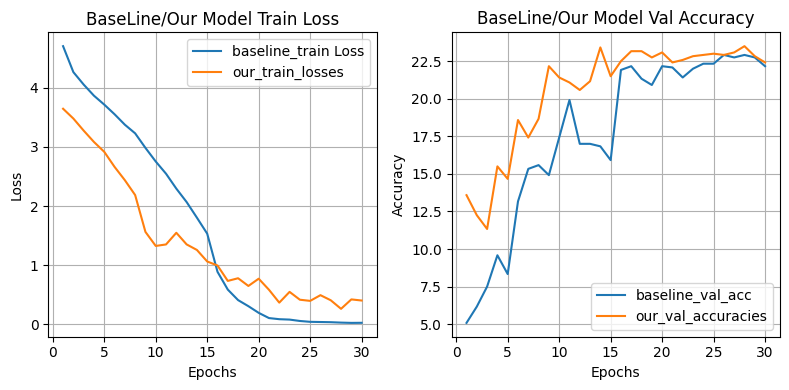

In [21]:
import matplotlib.pyplot as plt

# 그래프 크기
plt.figure(figsize=(8, 4))

# 첫 번째 그래프: 손실
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), baseline_train_losses, label='baseline_train Loss')
plt.plot(range(1, epochs+1), our_train_losses, label='our_train_losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BaseLine/Our Model Train Loss')
plt.legend()
plt.grid(True)

# 두 번째 그래프: 정확도
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), baseline_val_accuracies, label='baseline_val_acc')
plt.plot(range(1, epochs+1), our_val_accuracies, label='our_val_accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BaseLine/Our Model Val Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 결과 분석 및 평가

1. Baseline 모델 vs Our 모델 성능 비교

  • Baseline 모델은 라벨이 있는 데이터(labeled data)만 사용하여 학습한 모델이다.

  • Our 모델은 라벨이 있는 데이터(labeled data)와 라벨이 없는 데이터(unlabeled data) 모두를 활용하여 학습한 모델이다.
  
  <br>

 Train Loss 분석

  •	Baseline 모델의 손실이 점진적으로 감소하며 과적합 없이 안정적으로 수렴하는 모습을 보인다.

  •	Our 모델 역시 손실이 감소하지만, 초반에는 더 빠르게 감소하는 경향을 보인다.

  •	하지만 Epoch이 진행됨에 따라 Our 모델의 손실이 Baseline 모델과 비슷한 수준으로 수렴하며, 오히려 손실이 일정 수준에서 유지되는 경향이 보인다.

  <br>
 Validation Accuracy 분석

  •	Baseline 모델과 Our 모델의 최종 검증 정확도 차이가 크지 않다.

  •	Our 모델은 초반에 빠르게 정확도가 상승하지만, 이후에는 Baseline 모델과 거의 비슷한 수준으로 수렴한다.

  •	즉, 라벨이 없는 데이터(unlabeled data)를 활용했음에도 성능 향상이 제한적이었다.

  <br>

2. Our 모델의 성능이 기대보다 높지 않은 이유

  1. Pseudo-Label 신뢰도 문제

  •	Our 모델은 라벨이 없는 데이터를 활용하기 위해 Pseudo-Labeling 기법을 사용했다. 하지만 pseudo-label의 신뢰도가 낮으면 잘못된 레이블을 학습할 가능성이 높아진 것 같다.

  2. 임계값(Threshold) 설정 문제

	•	Pseudo-Label을 사용할 때, 임계값(threshold)을 설정하였는데 Threshold를 너무 높게 설정하면 학습할 데이터가 부족해지고, 너무 낮게 설정하면 잘못된 데이터까지 학습할 수 있다. 실험에서 사용된 Threshold(0.8)가 최적값이 아닐 가능성이 있으며, 조정이 필요할 것 같다.
  3.	Consistency Loss의 효과 부족

	•	Consistency Loss는 약한 증강(Weak Augmentation)과 강한 증강(Strong Augmentation)된 이미지 간 예측이 일관되도록 학습하는 역할을 한다. 하지만, consistency loss가 학습을 안정적으로 도와주지 못했거나, weight(λ2)가 너무 낮아 효과적으로 작동하지 않았을 가능성이 있다.